In [1]:
# Install yfinance library
# %pip install -q yfinance --upgrade --no-cache-dir

In [2]:
# Import the necessary libraries
import requests
import pandas as pd
import yfinance as yf
import bs4 as bs
import pickle
import requests
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
warnings.filterwarnings("ignore")
from drift import *

In [3]:
!wget --quiet -O "quarterly_statements.csv" "https://raw.githubusercontent.com/pilijevski/stock-prediction/main/lib/quarterly_statements.csv"

In [4]:
stocks = pd.read_csv("quarterly_statements.csv",index_col=0, parse_dates=True)

In [5]:
def get_snp_companies(subset='500'):
    WIKI_URL = f"http://en.wikipedia.org/wiki/List_of_S%26P_{subset}_companies"
    resp = requests.get(WIKI_URL)
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[:-1]
        tickers.append(ticker)

    return tickers

In [6]:
stock_symbols = get_snp_companies('500') + get_snp_companies('400') + get_snp_companies('600')

- calculate moving average over a year to fill some of the nans (as in the feature creation below)
- additional startistical features 

In [7]:
stocks = stocks.loc['2021-01-01':]
# stocks = stocks.loc['2022-01-01':]
stocks = stocks.loc[stocks.ticker.isin(stock_symbols)]
stocks['end_of_quarter'] = stocks.index

In [8]:
# remove commas from thousands, and replace values that have only '-' with nan
tmp = stocks['end_of_quarter'].copy()
for col in list(stocks.columns):
  try:
    stocks.loc[:, col] = stocks.loc[:, col].str.replace(',', '').replace(r'^-$', np.nan, regex=True)
  except:
    pass
# all percentage columns, remove the percent sign
percentage_columns = [col for col in stocks.columns if any(stocks[col].astype(str).str.contains('%'))]
for col in percentage_columns:
  stocks.loc[:, col] = stocks.loc[:, col].str.replace('%', '')
stocks['end_of_quarter'] = tmp

In [9]:
# stocks.loc[:, ~stocks.columns.isin(['end_of_quarter', 'ticker', 'industry', 'sector'])] = stocks.loc[:, ~stocks.columns.isin(['end_of_quarter', 'ticker', 'industry', 'sector'])].astype(float)

In [10]:
# _CALCULATED = '_calculated'
# # df.groupby('end_of_quartal')
# aggregated[f"Return on Equity (ROE){_CALCULATED}"] = 100 * aggregated['Net Income_mean'].astype('float')/aggregated["Shareholders' Equity"].astype('float')
# aggregated[f'Asset Turnover{_CALCULATED}'] = aggregated['Revenue'].astype('float')/aggregated['Total Assets'].astype('float')
# aggregated[f"Return on Assets (ROA){_CALCULATED}"] = 100 * aggregated['Net Income_mean'].astype('float')/aggregated["Total Assets"].astype('float')
# # avoid inf, add 10e-5
# aggregated[f'Earnings Yield{_CALCULATED}'] = 1 / (aggregated[ 'PE Ratio'].astype('float') + 10e-5)
# aggregated[f'Share Price{_CALCULATED}'] = aggregated['PE Ratio'].astype('float') * aggregated['EPS (Basic)'].astype('float')
# aggregated[f'FCF Yield{_CALCULATED}'] = aggregated['Free Cash Flow Per Share'].astype('float')/ (aggregated[f'Share Price{_CALCULATED}'].astype('float') + 10e-5)
# aggregated[['Dividend Per Share', 'Shares Outstanding (Basic)']].isna().sum()
# aggregated[f'DPS{_CALCULATED}'] = -1* aggregated[ 'Dividends Paid'].astype('float') / (aggregated['Shares Outstanding (Basic)'].astype('float') + 10e-5)
# aggregated[f'Dividents{_CALCULATED}'] = aggregated[f'DPS{_CALCULATED}'].astype('float') * aggregated['Shares Outstanding (Basic)'].astype('float')
# aggregated[[ 'dividends', f'DPS{_CALCULATED}',  'Dividend Per Share']].isna().sum()

In [11]:
# # Define a function to aggregate the data
# stocks = stocks.sort_index()
# # Apply the rolling window and aggregation
# rolled = stocks.loc[:, ~stocks.columns.isin(['end_of_quarter','industry', 'sector'])].groupby(['ticker']).rolling(window="365D")
# aggregated = rolled.aggregate(['mean', 'min', 'max', 'median', 'std']).reset_index()

# aggregated = aggregated.rename(columns={'level_1':'end_of_quarter'})
# columns = ['_'.join(col) for col in aggregated.columns]
# aggregated.columns = aggregated.columns.droplevel(0)
# aggregated.columns = columns

# aggregated = aggregated.rename(columns={'end_of_quarter_':'end_of_quarter', 'ticker_':'ticker'})
# stocks['end_of_quarter'] = stocks.index.values
# stocks = stocks.merge(aggregated, how='left', on=['ticker', 'end_of_quarter'])
# stocks.set_index('end_of_quarter', inplace=True)

In [12]:
# meta_data = []
# N = 1600
# for ticker in tqdm(stock_symbols):
#   try:
#     stock = yf.Ticker(ticker)
#     stock_info = stock.info
#   except:
#     continue
#   stock_periods = stocks[stocks.ticker == ticker].index

#   if len(stock_periods) < 8:
#     print(f'The stock with ticker:{ticker} has less than 8 periods reported')
#     continue
#   for i in range(len(stock_periods) - 1, -1, -1):
#     stock_features = []

#     try:
#       dividends = stock.dividends[stock_periods[i]- DateOffset(months=3):stock_periods[i]][-1]
#     except:
#       dividends = np.nan

#     try:
#       fte = stock_info['fullTimeEmployees']
#     except:
#       fte = np.nan

#     try:
#       auditrisk = stock_info['auditRisk']
#     except:
#       auditrisk = np.nan
#     try:
#       compensationrisk = stock_info['compensationRisk']
#     except:
#       compensationrisk = np.nan

#     try:
#       boardrisk = stock_info['boardRisk']
#     except:
#       boardrisk = np.nan

#     try:
#       shareholderrightsrisk = stock_info['shareHolderRightsRisk']
#     except:
#       shareholderrightsrisk = np.nan
#     try:
#       maxage = stock_info['maxAge']
#     except:
#       maxage = np.nan
#     try:
#       industry = stock_info['industry']
#     except:
#       industry =  np.nan

#     try:
#       sector = stock_info['sectorKey']
#     except:
#       sector = np.nan
#     stock_features += [stock_periods[i], ticker, industry, sector, fte, auditrisk, compensationrisk,
#                     boardrisk, shareholderrightsrisk, maxage, dividends]
#     hist = stock.history(start=stock_periods[i] - DateOffset(months=3), end=stock_periods[i])
#     try:
#       hist['week_number'] = hist.index.week
#     except:
#       continue
#     weekly_mean_close = hist.groupby('week_number')['Close'].mean()
#     stock_features += list(weekly_mean_close.values[:10])
#     stock_feature_columns = ['end_of_quarter','ticker', 'industry', 'sector', 'fte', 'auditrisk',
#                             'compensationrisk', 'boardrisk', 'shareholderrightsrisk',
#                             'maxage', 'dividends'] + [f'weekly_price_{w}' for w in range(len(list(weekly_mean_close.values[:10])))] + ['increase']

#     try:
#       hist = stock.history(start=stock_periods[i], end=stock_periods[i] + DateOffset(months=3))
#       next_quarter_increase = (hist['Close'][-1] - hist['Close'][0]) / hist['Close'][0]
#       stock_features += [next_quarter_increase]
#       meta_data.append(stock_features)
#     except:
#       continue
#   if N < 0:
#     break
#   N -= 1

In [13]:
# meta_df = pd.DataFrame(meta_data)#, columns=stock_feature_columns)
# meta_df.to_csv('meta_df_2024_26_03.csv', index=False)

In [14]:
meta_df = pd.read_csv('meta_df_2020.csv')
meta_df.end_of_quarter = pd.to_datetime(meta_df.end_of_quarter)

In [15]:
meta_df.shape

(23484, 22)

In [16]:
df = pd.merge(stocks, meta_df, how='left', on=['ticker', 'end_of_quarter'])
# df

In [17]:
df.shape

(17984, 145)

In [18]:
# We keep only ratios for now, we don't know how to normalize other values e.g., Cash Flow properly
features_no_meta = ['ticker', 'Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share', 'Book Value Per Share',
         'Share Issuance / Repurchase', 'Debt Issued / Paid', 'Cash Growth', 'Debt Growth', 'Free Cash Flow Growth',
         'Free Cash Flow Margin', 'Free Cash Flow Per Share', 'Revenue Growth (YoY)', 'Interest Expense / Income',
         'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth', 'Free Cash Flow Per Share.1',
         'Dividend Per Share', 'Dividend Growth', 'Gross Margin', 'Operating Margin', 'Profit Margin', 'EBIT Margin',
         'Market Cap Growth', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
         'Quick Ratio','Current Ratio','Interest Coverage', 'Return on Capital (ROIC)','Dividend Yield','Payout Ratio',
         'Buyback Yield / Dilution', 'Total Shareholder Return', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Earnings Yield',
         'FCF Yield','industry', 'sector', 'fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk','end_of_quarter','increase']

features = ['ticker', 'Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share', 'Book Value Per Share',
         'Share Issuance / Repurchase', 'Debt Issued / Paid', 'Cash Growth', 'Debt Growth', 'Free Cash Flow Growth',
         'Free Cash Flow Margin', 'Free Cash Flow Per Share', 'Revenue Growth (YoY)', 'Interest Expense / Income',
         'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth', 'Free Cash Flow Per Share.1',
         'Dividend Per Share', 'Dividend Growth', 'Gross Margin', 'Operating Margin', 'Profit Margin', 'EBIT Margin',
         'Market Cap Growth', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
         'Quick Ratio','Current Ratio','Interest Coverage', 'Return on Capital (ROIC)','Dividend Yield','Payout Ratio',
         'Buyback Yield / Dilution', 'Total Shareholder Return', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Earnings Yield',
         'FCF Yield','industry', 'sector', 'fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk','end_of_quarter','increase']

numerical_features = ['Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share', 'Book Value Per Share',
         'Share Issuance / Repurchase', 'Debt Issued / Paid', 'Cash Growth', 'Debt Growth', 'Free Cash Flow Growth',
         'Free Cash Flow Margin', 'Free Cash Flow Per Share', 'Revenue Growth (YoY)', 'Interest Expense / Income',
         'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth', 'Free Cash Flow Per Share.1',
         'Dividend Per Share', 'Dividend Growth', 'Gross Margin', 'Operating Margin', 'Profit Margin', 'EBIT Margin',
         'Market Cap Growth', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
         'Quick Ratio','Current Ratio','Interest Coverage', 'Return on Capital (ROIC)','Dividend Yield','Payout Ratio',
         'Buyback Yield / Dilution', 'Total Shareholder Return', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Earnings Yield',
         'FCF Yield','fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk','increase']

numerical_features = list(df.columns)
numerical_features.remove('ticker')
numerical_features.remove('end_of_quarter')
numerical_features.remove('industry')
numerical_features.remove('sector')
numerical_features.remove('increase')
numerical_features.remove('year')
# numerical_features.remove('quarter_year')
df['increase'] = df['increase'].astype('float')


In [19]:
df[numerical_features] = df[numerical_features].astype('float')

In [20]:
df = df.loc[df.end_of_quarter > '2021-01-01']

In [22]:
df['quarter_year'] = df['end_of_quarter'].dt.to_period('Q')

In [23]:
df_mean = df.groupby(['quarter_year', 'industry']).mean()
df_std = df.groupby(['quarter_year', 'industry']).std()
dff = pd.merge(left=df, right=df_mean, how='left', on=['quarter_year', 'industry'], suffixes=["", "_mean"])
dff = pd.merge(left=dff, right=df_std, how='left', on=['quarter_year', 'industry'], suffixes=["", "_std"])

new_numerical_features = []

for col in numerical_features:
  dff[col] = (dff[col] - dff[col + "_mean"]) / dff[col + "_std"]
  new_numerical_features.append(col)
  new_numerical_features.append(col + "_mean")
  new_numerical_features.append(col + "_std")
df = dff

In [24]:
numerical_features = new_numerical_features

In [25]:
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median()).fillna(0)

In [27]:
# Define function to compute PSI
def calculate_psi(expected, actual, buckets):
    if len(expected) < 2:
        expected = actual
    if len(actual) < 2:
        actual = expected

    expected_freq = np.histogram(expected, bins=buckets)[0]
    actual_freq = np.histogram(actual, bins=buckets)[0]
    # To avoid division by zero, adding a small number to denominators
    expected_freq = np.where(expected_freq == 0, 1e-10, expected_freq)
    actual_freq = np.where(actual_freq == 0, 1e-10, actual_freq)
    
    expected_pct = expected_freq / np.sum(expected_freq)
    actual_pct = actual_freq / np.sum(actual_freq)
    
    psi = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))
    
    return psi

# Define function to compute PSI drift over quarters
def psi_drift_over_quarters(df, feature, years = [ '2021-01-01', '2022-01-01', '2023-01-01']):
    psi_values = []
    for i in range(len(years)-1):
        for j in range(i+1, len(years)):
            # Divide data into quarters
            start_date = pd.to_datetime(years[i])
            end_date = start_date + pd.DateOffset(years=1)
            # print(start_date, end_date)
            quarter_data_prev = df.loc[(df.end_of_quarter >= start_date) & (df.end_of_quarter < end_date), feature]

            start_date = pd.to_datetime(years[j])
            end_date = start_date + pd.DateOffset(years=1)
            quarter_data = df.loc[(df.end_of_quarter >= start_date) & (df.end_of_quarter < end_date), feature]
            # Compute PSI between consecutive quarters

            psi = calculate_psi(quarter_data_prev, quarter_data, 10)  # Assuming 10 buckets
            psi_values.append(psi)
    
    return psi_values



In [28]:
psi_results = {}
cols = [i for i in numerical_features if i not in ['ticker', 'end_of_quarter', 'year']]
# Perform PSI drift analysis over quarters for each numerical feature
psi_results = {}
for col in cols:
    psi_results[col] = psi_drift_over_quarters(df, col)

# psi_results
# # Convert results to DataFrame
feats_to_keep = []
for p in psi_results:
    # val = max(psi_results[p])
    # if val < .25:
    #     feats_to_keep.append(p)
    count = 0
    for num in psi_results[p]:
        if num < .5: 
            # print(f"{p}: {psi_results[p]}")
            count+=1
    if count >= 2:
        feats_to_keep.append(p)


print(len(feats_to_keep))
print(len(numerical_features))


244
417


In [29]:
feats_to_keep.extend(['ticker', 'industry', 'sector', 'fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk','end_of_quarter','increase'])

### Feature design by definitions 

In [52]:
# _CALCULATED = '_calculated'
# df.groupby('end_of_quartal')
# df[f"Return on Equity (ROE){_CALCULATED}"] = 100 * df['Net Income'].astype('float')/df["Shareholders' Equity"].astype('float')
# df[f'Asset Turnover{_CALCULATED}'] = df['Revenue'].astype('float')/df['Total Assets'].astype('float')
# df[f"Return on Assets (ROA){_CALCULATED}"] = 100 * df['Net Income'].astype('float')/df["Total Assets"].astype('float')
# # avoid inf, add 10e-5
# df[f'Earnings Yield{_CALCULATED}'] = 1 / (df[ 'PE Ratio'].astype('float') + 10e-5)
# df[f'Share Price{_CALCULATED}'] = df['PE Ratio'].astype('float') * df['EPS (Basic)'].astype('float')
# df[f'FCF Yield{_CALCULATED}'] = df['Free Cash Flow Per Share'].astype('float')/ (df[f'Share Price{_CALCULATED}'].astype('float') + 10e-5)
# df[['Dividend Per Share', 'Shares Outstanding (Basic)']].isna().sum()
# df[f'DPS{_CALCULATED}'] = -1* df[ 'Dividends Paid'].astype('float') / (df['Shares Outstanding (Basic)'].astype('float') + 10e-5)
# df[f'Dividents{_CALCULATED}'] = df[f'DPS{_CALCULATED}'].astype('float') * df['Shares Outstanding (Basic)'].astype('float')
# df[[ 'dividends', f'DPS{_CALCULATED}',  'Dividend Per Share']].isna().sum()

# missing values analysis

In [28]:
missing_pct = df[numerical_features].isna().mean()
columns_missing = missing_pct[missing_pct > .20].index
df[columns_missing]

,Net Cash / Debt Growth,Net Cash Per Share,Free Cash Flow Growth,Net Income Growth,EPS Growth,Dividend Per Share,Dividend Growth,Quick Ratio,Current Ratio,Dividend Yield,Payout Ratio,Return on Equity (ROE),Return on Assets (ROA),Earnings Yield,FCF Yield
0,4.85,4.31,-86.04,-5.01,-2.99,0.390,2.63,1.10,1.37,3.00,60.00,NaN,NaN,NaN,NaN
1,32.20,4.72,-40.91,36.25,36.92,0.390,2.63,1.18,1.47,3.00,43.30,NaN,NaN,NaN,NaN
2,54.55,5.16,58.27,40.60,41.18,0.390,2.63,1.13,1.39,3.00,40.20,NaN,NaN,NaN,NaN
3,26.23,4.45,39.20,5.52,6.85,0.390,2.63,1.11,1.39,3.20,49.40,NaN,NaN,NaN,NaN
4,22.67,4.06,94.01,-6.73,-5.63,0.380,2.70,1.13,1.41,3.10,55.90,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12047,NaN,-5.57,NaN,-21.24,-21.39,0.150,200.00,1.45,1.67,0.80,10.90,NaN,NaN,NaN,NaN
12048,NaN,-5.07,NaN,18.16,17.32,0.100,100.00,1.66,1.86,0.50,4.70,NaN,NaN,NaN,NaN
12049,NaN,-6.27,99.68,65.78,64.91,0.100,300.00,1.33,1.48,0.50,3.50,NaN,NaN,NaN,NaN
12050,NaN,-8.66,290.62,292.54,289.89,0.050,100.00,1.17,1.32,0.40,1.40,NaN,NaN,NaN,NaN


In [30]:
import seaborn as sns

In [58]:
# for c in columns_missing[:15]:
#     plt.figure()
#     print(f"{c}: {df[c].astype('float').median()}")
#     sns.histplot(df[c].astype('float').dropna(), bins = 30)

In [34]:
# get all new created features
# new_features = [c for c in df.columns if _CALCULATED in c]

In [35]:
# df[new_features].isna().sum()

Return on Equity (ROE)_calculated      57
Asset Turnover_calculated              54
Return on Assets (ROA)_calculated      57
Earnings Yield_calculated              98
Share Price_calculated                143
FCF Yield_calculated                  226
DPS_calculated                       3086
Dividents_calculated                 3086
dtype: int64

In [36]:
# numerical_features += new_features

In [37]:
# features += new_features

# Feat norm 

In [30]:
tmp = df.copy()

In [31]:
df = df[feats_to_keep]

In [32]:
# one hot encoding of industry and sector
one_hot_encoded_industry = pd.get_dummies(df['industry'], prefix='industry')
one_hot_encoded_sector = pd.get_dummies(df['sector'], prefix='sector')
df = pd.concat([df, one_hot_encoded_industry, one_hot_encoded_sector], axis=1)
df.drop(['industry', 'sector'], axis=1, inplace=True)

In [33]:
df.increase.max(), df.increase.min()

(3.287690168494993, -0.7172177799983862)

In [34]:
# where target variable does not exists, remove those rows
df.dropna(axis=0, inplace=True, subset=['increase'])

In [35]:
df_test = df.groupby('ticker', as_index=False).first()
df_train = df.loc[~df.end_of_quarter.isin(list(df_test.end_of_quarter.values))]
df_train.shape, df_test.shape

((14961, 400), (1485, 400))

In [36]:
y_train = df_train[['increase', 'ticker']]
y_test = df_test[['increase', 'ticker']]
df_test = df_test.drop(['ticker', 'end_of_quarter', 'increase'], axis=1)
df_train = df_train.drop(['ticker', 'end_of_quarter', 'increase'], axis=1)

In [37]:
y_train['increase_real_values'] = y_train.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
y_train.increase[y_train.increase_real_values >= class_thresholds[3]] = 4
y_train.increase[(y_train.increase_real_values >= class_thresholds[2]) & (y_train.increase_real_values < class_thresholds[3])] = 3
y_train.increase[(y_train.increase_real_values >= class_thresholds[1]) & (y_train.increase_real_values < class_thresholds[2])] = 2
y_train.increase[(y_train.increase_real_values > class_thresholds[0]) & (y_train.increase_real_values < class_thresholds[1])] = 1
y_train.increase[y_train.increase_real_values <= class_thresholds[0]] = 0

In [38]:
class_counts = dict(zip(*np.unique(y_train.increase.values, return_counts=True)))
class_weights = {class_label: len(y_train.increase.values) / (len(np.unique(y_train.increase.values)) * count) for class_label, count in class_counts.items()}
class_counts, class_weights

({0.0: 3538, 1.0: 3962, 2.0: 3720, 3.0: 2155, 4.0: 1586},
 {0.0: 0.8457320520067835,
  1.0: 0.7552246340232206,
  2.0: 0.8043548387096774,
  3.0: 1.388491879350348,
  4.0: 1.8866330390920554})

In [39]:
# class_weights[0]*=5
# class_weights[4]*=5

In [40]:
df_train.fillna(np.iinfo('int').max, inplace=True)
df_test.fillna(np.iinfo('int').max, inplace=True)

In [41]:
# Assuming you have your features (x) and labels (y) ready, split the data.
X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.1, random_state=42)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
# We fit a classifier to predict the increase in percentage into the next Q
# Initialize
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)#, class_weight=class_weights)
# rf_classifier = xgboost.XGBClassifier(n_estimators=1000, random_state = 42, objective='multi:softprob')
# rf_classifier = LogisticRegression(random_state=42)
# Fit the model to the training data
rf_classifier.fit(X_train, Y_train.increase)

RandomForestClassifier(n_estimators=1000, random_state=42)

# New features:

In [43]:
# Predict on the test set
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 15
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
2495,ADBE,4.0,2.0,0.007936
6487,HELE,4.0,2.0,0.028973
9701,ANF,4.0,4.0,0.553470
5353,RCUS,4.0,0.0,-0.225917
15786,KEX,4.0,4.0,0.243953
15546,LXP,4.0,4.0,0.232941
16664,NEOG,4.0,3.0,0.126812
575,ATGE,4.0,1.0,-0.023868
2685,XPO,4.0,1.0,-0.039876
13720,TILE,4.0,2.0,0.081181


In [44]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,1.0,434,420
1,0.0,423,381
2,2.0,419,365
3,3.0,126,192
4,4.0,95,139


Accuracy: 0.39345357381429524
Confusion matrix: 
 [[202  85  55  13  10]
 [ 97 175 113  25  10]
 [ 71 108 149  39  14]
 [ 22  46  68  29  27]
 [ 31  20  34  20  34]]


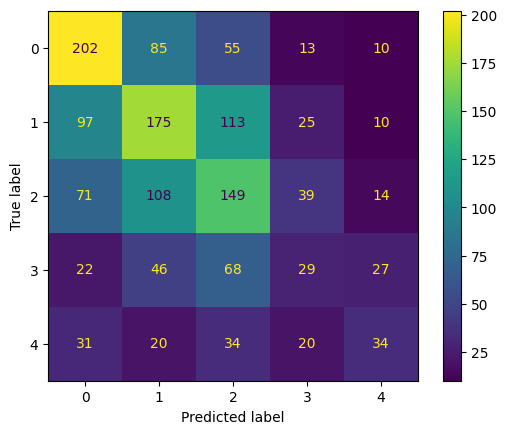

In [45]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(p.true, p.preds)).plot()
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

In [46]:
proba = rf_classifier.predict_proba(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])[rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))])== np.max(rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]))][:, -1]

In [47]:
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
p[p.preds == np.max(p.preds.values)]
b = p[p.preds == np.max(p.preds.values)]
b['proba'] = proba
b.sort_values(by='proba')[::-1].iloc[:10]

,ticker,preds,increase,proba
1256,STX,4.0,0.040061,0.347
90,ANET,4.0,0.319264,0.283
880,MPC,4.0,0.313874,0.277
1217,SMCI,4.0,2.732703,0.269
860,MKTX,4.0,-0.232850,0.262
98,APA,4.0,-0.045832,0.247
1421,WDC,4.0,0.247279,0.227


In [48]:
f'We have gain (positive) or loss (negative) of {b.sort_values(by="proba")[::-1].iloc[:10].increase.mean()  * 100}% on the invested 10 stocks'

'We have gain (positive) or loss (negative) of 48.207119921127024% on the invested 10 stocks'

In [49]:
p['increase_real_values'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase[p.increase_real_values >= class_thresholds[3]] = 4
p.increase[(p.increase_real_values >= class_thresholds[2]) & (p.increase_real_values < class_thresholds[3])] = 3
p.increase[(p.increase_real_values >= class_thresholds[1]) & (p.increase_real_values < class_thresholds[2])] = 2
p.increase[(p.increase_real_values > class_thresholds[0]) & (p.increase_real_values < class_thresholds[1])] = 1
p.increase[p.increase_real_values <= class_thresholds[0]] = 0


Accuracy: 0.2785571142284569
Confusion matrix: 
 [[16 17  9  0  1]
 [18 74 28  0  1]
 [22 84 44  9  1]
 [15 45 48  1  0]
 [13 26 23  0  4]]


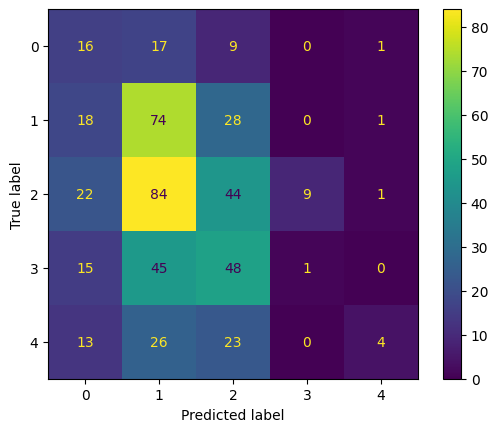

In [50]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(p.increase, p.preds)).plot()
print(f'Confusion matrix: \n {confusion_matrix(p.increase, p.preds)}')

In [118]:
p.preds.value_counts().index, p.preds.value_counts().values, p.increase.value_counts().values

(Index([1.0, 2.0, 3.0, 4.0, 0.0], dtype='float64', name='preds'),
 array([166, 133, 104,  55,  41]),
 array([164, 123, 106,  66,  40]))

In [103]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.increase.value_counts().values})

,value,pred_counts,true_counts
0,1.0,166,164
1,2.0,133,123
2,3.0,104,106
3,4.0,55,66
4,0.0,41,40


# fillna median:

In [82]:
# Predict on the test set
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 10
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
3476,GMS,4.0,1.0,-0.021241
875,DGII,4.0,2.0,0.092937
11030,MHO,4.0,1.0,-0.036128
7666,ARCB,4.0,2.0,0.028846
10039,SLP,4.0,3.0,0.183754
362,TER,4.0,3.0,0.110052
4290,WGO,4.0,1.0,-0.000845
11029,MHO,4.0,4.0,0.653145
3943,MLI,4.0,2.0,0.032526
1217,SABR,4.0,0.0,-0.345779


In [83]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,0.0,353,259
1,1.0,313,259
2,2.0,221,234
3,3.0,82,142
4,4.0,56,131


In [84]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

Accuracy: 0.29853658536585365
Confusion matrix: 
 [[128  57  49  14  11]
 [ 74  93  57  25  10]
 [ 70  80  53  19  12]
 [ 37  46  34  17   8]
 [ 44  37  28   7  15]]


In [85]:
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
K = 10
p.sort_values(by='preds')[::-1][:K]

,ticker,preds,increase
182,BLDR,4.0,0.276575
1396,WAT,4.0,0.072515
603,HBAN,4.0,0.058320
736,KLAC,4.0,0.272560
235,CCL,4.0,0.027224
1347,URI,4.0,0.267942
147,BAC,4.0,0.114284
71,AMD,4.0,0.289363
137,AXON,4.0,0.256170
88,ANET,4.0,0.315426


In [86]:
f'We have gain (positive) or loss (negative) of {p.sort_values(by="preds")[::-1][:K].increase.mean() * 100}% on the invested {K} stocks'

'We have gain (positive) or loss (negative) of 19.503807971647312% on the invested 10 stocks'

In [87]:
p['increase_real_values'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase[p.increase_real_values >= class_thresholds[3]] = 4
p.increase[(p.increase_real_values >= class_thresholds[2]) & (p.increase_real_values < class_thresholds[3])] = 3
p.increase[(p.increase_real_values >= class_thresholds[1]) & (p.increase_real_values < class_thresholds[2])] = 2
p.increase[(p.increase_real_values > class_thresholds[0]) & (p.increase_real_values < class_thresholds[1])] = 1
p.increase[p.increase_real_values <= class_thresholds[0]] = 0

In [88]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.increase, p.preds)}')

Accuracy: 0.312625250501002
Confusion matrix: 
 [[15 20  2  3  0]
 [17 63 24  2  0]
 [22 76 53 10  3]
 [23 46 34 19  1]
 [12 21 14 13  6]]


In [89]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.increase.value_counts().values})

,value,pred_counts,true_counts
0,1.0,226,164
1,2.0,127,123
2,0.0,89,106
3,3.0,47,66
4,4.0,10,40


# Baseline output:

In [80]:
# Predict on the test set
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 10
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
6160,RAMP,4.0,2.0,0.009804
10446,ZION,4.0,4.0,0.309943
2999,NVRI,4.0,2.0,0.048589
858,BSIG,4.0,0.0,-0.148806
6208,SBCF,4.0,1.0,-0.006335
7456,POWL,4.0,4.0,0.368213
8254,PBI,4.0,0.0,-0.146893
10829,X,4.0,4.0,0.298680
1353,BLD,4.0,4.0,0.255382
418,MDC,4.0,3.0,0.184194


In [81]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,0.0,382,259
1,1.0,329,259
2,2.0,208,234
3,3.0,67,142
4,4.0,39,131


In [82]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

Accuracy: 0.31121951219512195
Confusion matrix: 
 [[136  65  41  11   6]
 [ 79 101  50  20   9]
 [ 71  86  54  15   8]
 [ 48  41  35  15   3]
 [ 48  36  28   6  13]]


In [83]:
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
K = 10
p.sort_values(by='preds')[::-1][:K]

,ticker,preds,increase
88,ANET,4.0,0.315426
184,BLK,4.0,0.058710
252,CFG,4.0,0.078878
1347,URI,4.0,0.267942
71,AMD,4.0,0.289363
1393,WAB,4.0,0.150687
1396,WAT,4.0,0.072515
235,CCL,4.0,0.027224
920,NFLX,4.0,0.329157
1368,VLO,4.0,0.308587


In [84]:
f'We have gain (positive) or loss (negative) of {p.sort_values(by="preds")[::-1][:K].increase.mean() * 100}% on the invested {K} stocks'

'We have gain (positive) or loss (negative) of 18.984905341196594% on the invested 10 stocks'

In [85]:
p['increase_real_values'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase[p.increase_real_values >= class_thresholds[3]] = 4
p.increase[(p.increase_real_values >= class_thresholds[2]) & (p.increase_real_values < class_thresholds[3])] = 3
p.increase[(p.increase_real_values >= class_thresholds[1]) & (p.increase_real_values < class_thresholds[2])] = 2
p.increase[(p.increase_real_values > class_thresholds[0]) & (p.increase_real_values < class_thresholds[1])] = 1
p.increase[p.increase_real_values <= class_thresholds[0]] = 0

In [86]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.increase, p.preds)}')

Accuracy: 0.28857715430861725
Confusion matrix: 
 [[21 14  3  1  1]
 [20 66 17  3  0]
 [30 82 38 10  4]
 [25 44 40 13  1]
 [19 12 19 10  6]]


In [87]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.increase.value_counts().values})

,value,pred_counts,true_counts
0,1.0,218,164
1,2.0,117,123
2,0.0,115,106
3,3.0,37,66
4,4.0,12,40


<Figure size 1600x1600 with 0 Axes>

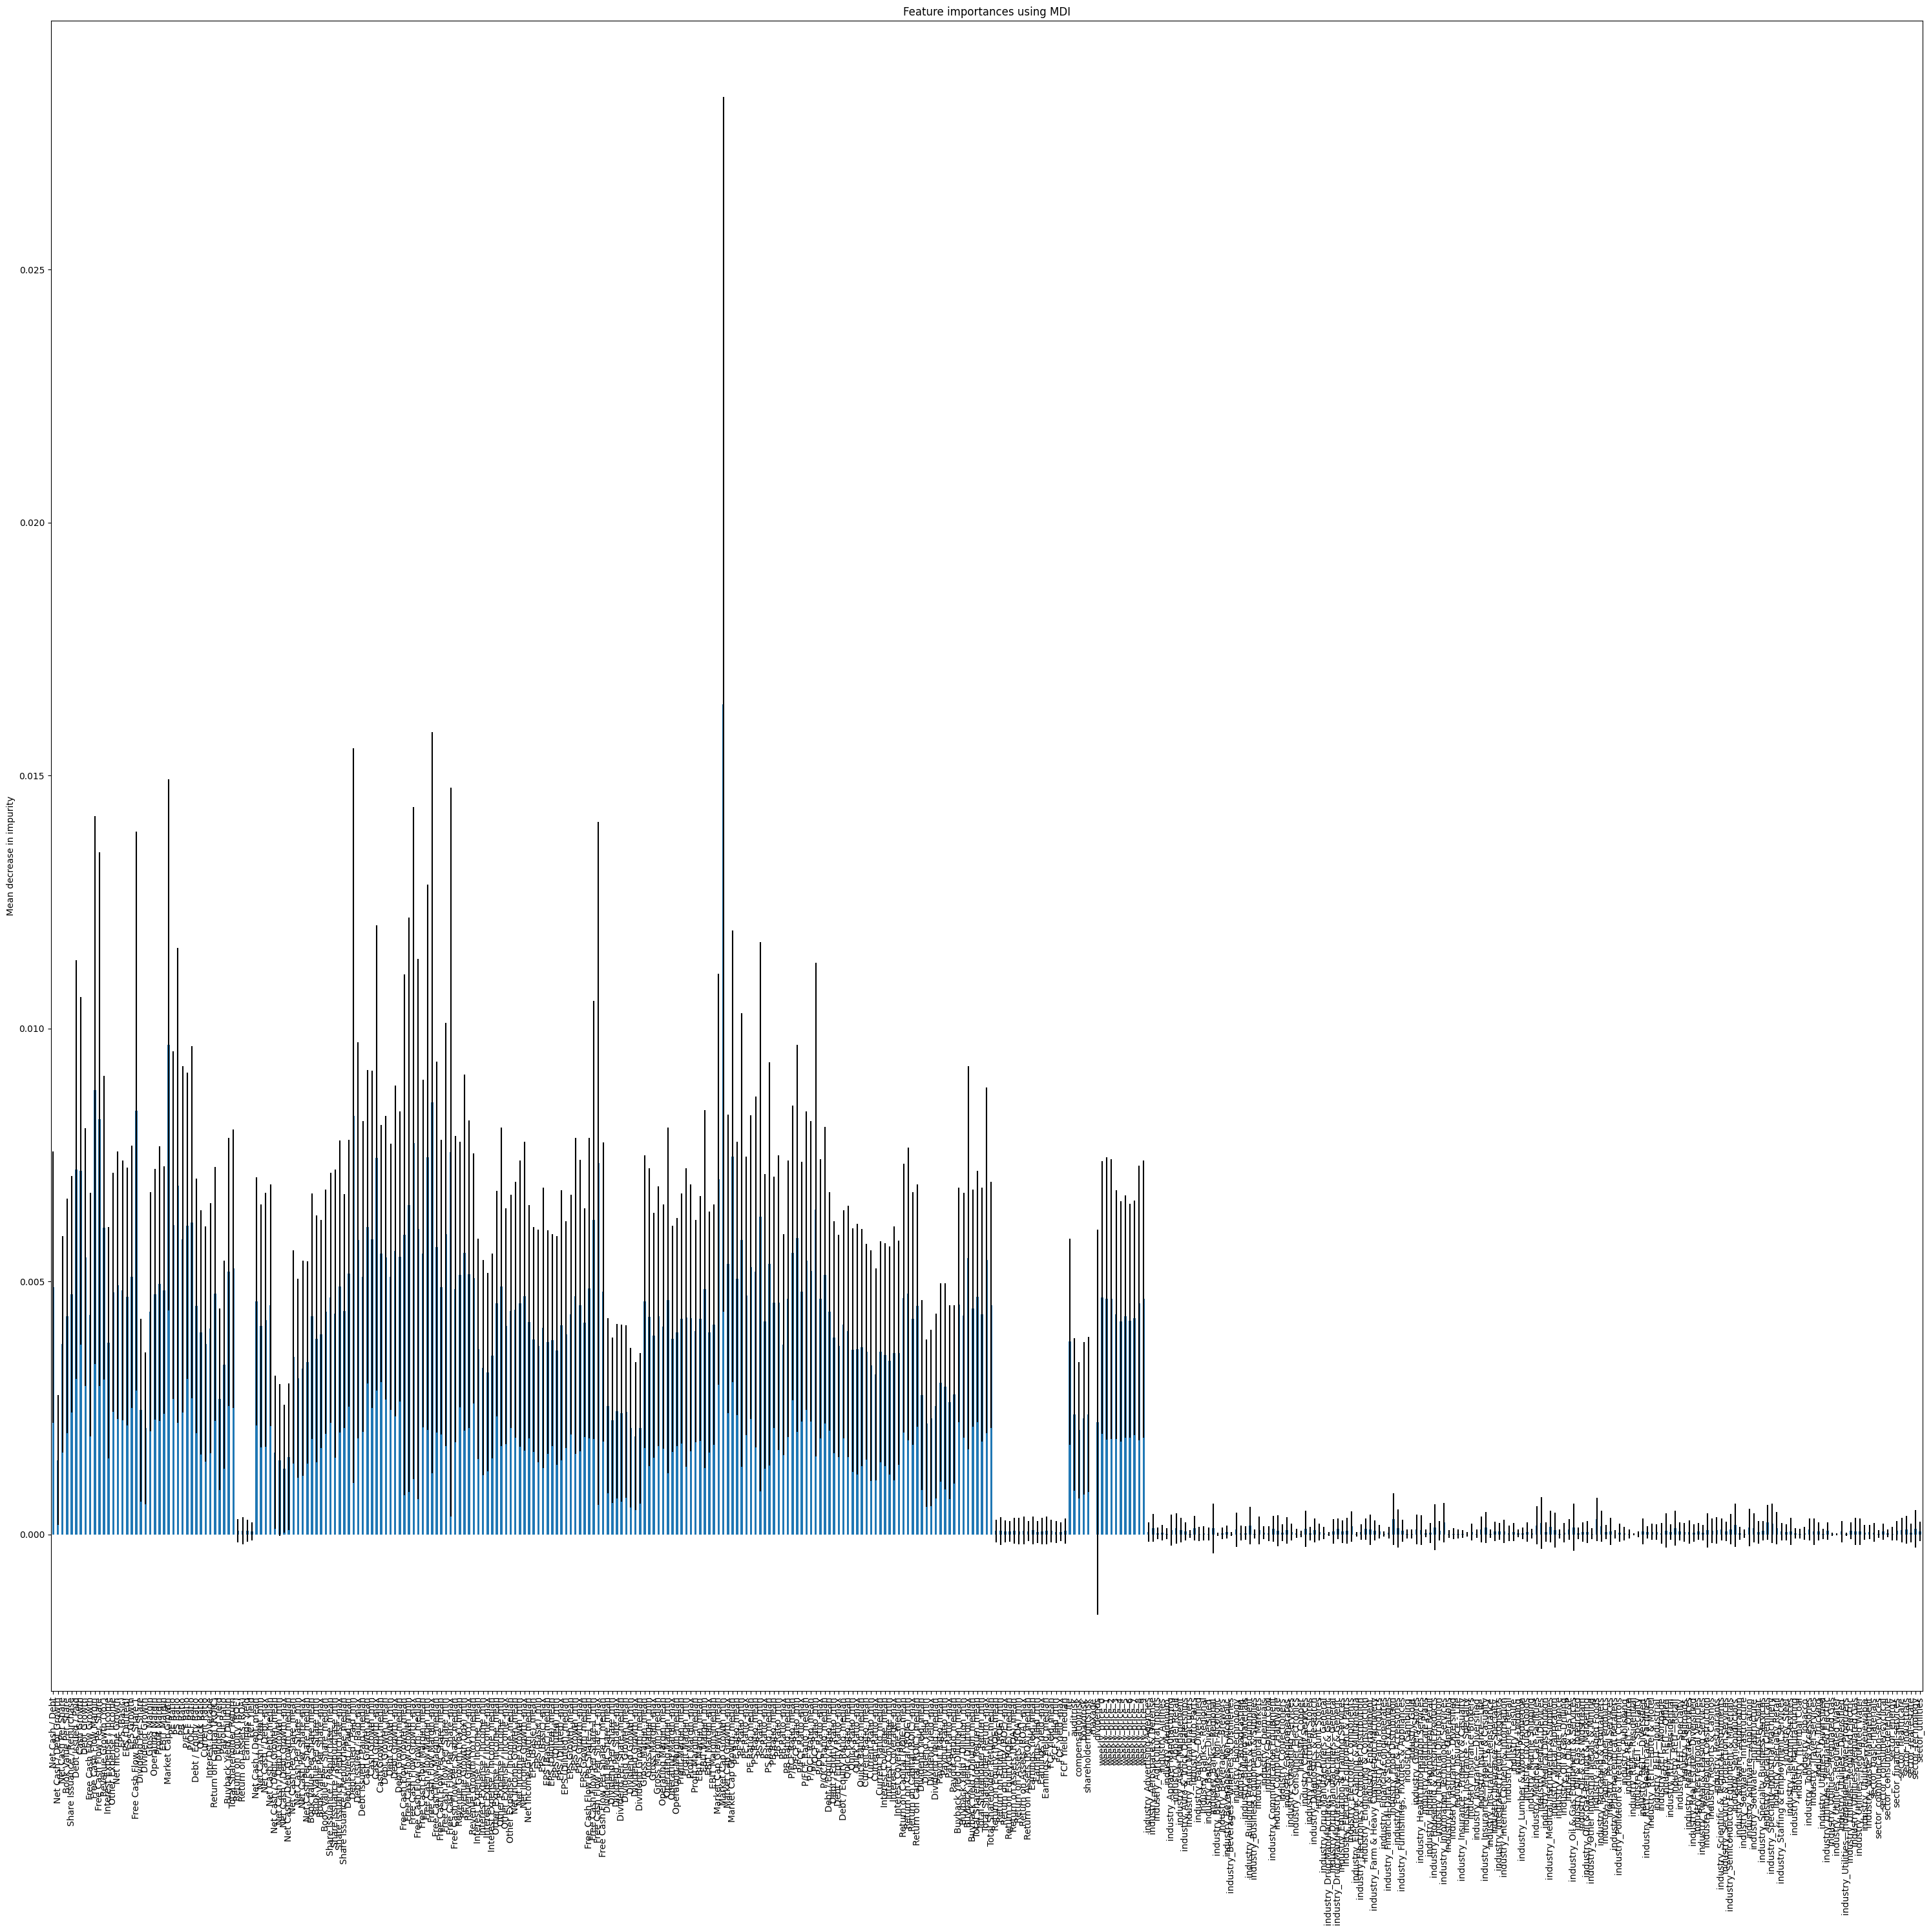

In [119]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=list(df_train.columns))
plt.figure(figsize=(16,16))
fig, ax = plt.subplots(figsize=(30,30))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_importances_plot.png')